# Disaster tweets EDA

In [141]:
import re
from typing import Callable

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm.notebook import tqdm

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
sns.set_style("darkgrid")
sns.set_palette("colorblind")

target_colors = ["tab:blue", "tab:red"]

In [2]:
%load_ext lab_black

## Import dataset

In [3]:
dtypes = {
    "id": np.int16,
    "target": np.int8,
    "location": str,
    "keyword": str,
    "text": str,
}

df_train = pd.read_csv("./data/train.csv", dtype=dtypes)

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Missing values

- `location` has ~33% missing values.
- `keyword` has ~1% missing values.

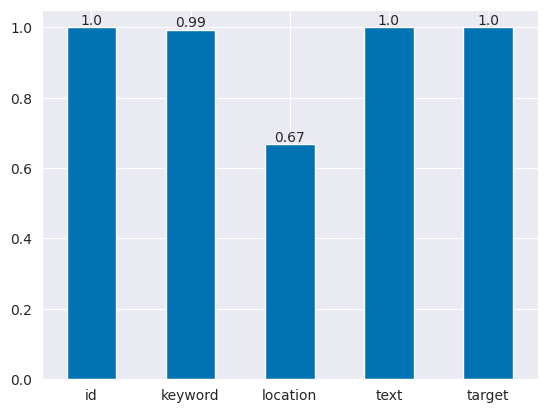

In [5]:
ax = (1 - df_train.isna().sum() / df_train.shape[0]).plot(kind="bar", rot=0)

plt.bar_label(
    container=ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
plt.show()

## Target distribution

There are less tweets about real disasters.

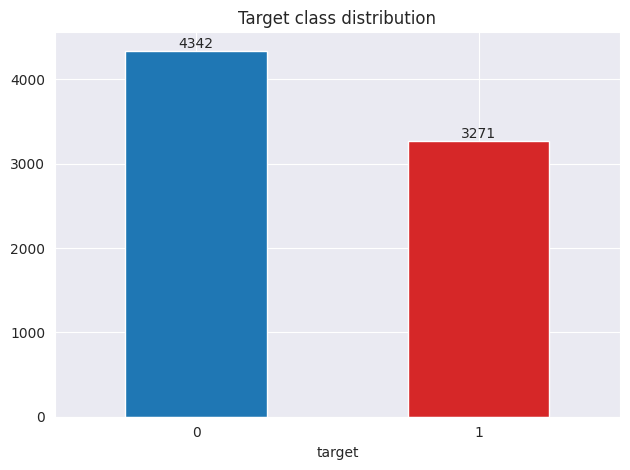

In [6]:
ax = df_train["target"].value_counts().plot.bar(rot=0, color=target_colors)

plt.title("Target class distribution")
plt.bar_label(
    ax.containers[0],
    labels=[val for val in ax.containers[0].datavalues],
)
plt.tight_layout()
plt.show()

## Preprocessing

### Extract extra informations in tweets text

In [7]:
regex_map = {
    "hashtag": r"#\w+",
    "link": r"\S*https?:\S*",
    "mention": r"@\w+",
}


def get_matches_str(text: str, pattern: str, skip: int = 1) -> str:
    """Find substrings matching a given pattern and concat them into a new string.
    If no match is found, returns 'no'.
    """
    matches = re.finditer(pattern, text)
    return " ".join([match.group(0)[skip:] for match in matches]) or "no"


def extract_tweet_infos(df: pd.DataFrame) -> pd.DataFrame:
    """d"""
    df_t = df.copy()

    for info in ["hashtag", "link", "mention"]:
        skip = 0 if info == "link" else 1
        df_t[info] = df_t["text"].apply(
            lambda x: get_matches_str(x, pattern=regex_map.get(info), skip=skip)
        )

    return df_t

### Text cleaning

In [8]:
def clean_text(text: str) -> str:
    """Apply preprocessing on text string."""
    text_lower = text.lower()
    text_no_link = re.sub(r"\S*https?:\S*", "", text_lower)
    text_no_special = re.sub(
        r"[^\w\d\s]", "", text_no_link
    )  # remove punctuation and special chars
    text_no_hashtag = re.sub(r"#", "", text_no_special)
    text_no_newline = re.sub(r"\n", "", text_no_hashtag)
    text_monospace = re.sub("\s+", " ", text_no_newline).strip()

    return text_monospace

In [9]:
example = df_train["text"][50]
print(f"Pre-cleaning {'':-<10} {example}")
print(f"Post-cleaning {'':-<10} {clean_text(example)}")

Pre-cleaning ---------- Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
Post-cleaning ---------- deputies man shot before brighton home set ablaze


### NLP preprocessing

In [10]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

pos_map = {
    "NN": "n",
    "NNP": "n",
    "NNPS": "n",
    "NNS": "n",
    "VB": "v",
    "VBD": "v",
    "VBG": "v",
    "VBN": "v",
    "VBP": "v",
    "VBZ": "v",
    "JJ": "a",
    "JJR": "a",
    "JJS": "a",
    "RB": "r",
    "RBR": "r",
    "RBS": "r",
}


def nlp_preprocess(text: str) -> str:
    # Tokenise each word, remove stop words and tag them
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    tags = nltk.pos_tag(filtered_tokens)

    # Lemmatization
    lem_words = []
    for tag in tags:
        pos = pos_map.get(tag[1], "n")  # map word tag to lem pos
        lem_words.append(lemmatizer.lemmatize(tag[0], pos=pos))

    return " ".join(lem_words)

In [11]:
clean_example = clean_text(example)
nlp_example = nlp_preprocess(clean_example)

In [12]:
print(f"Pre-nlp {'':-<10} {clean_example}")
print(f"Post-nlp {'':-<10} {nlp_example}")

Pre-nlp ---------- deputies man shot before brighton home set ablaze
Post-nlp ---------- deputy man shoot brighton home set ablaze


### Fill in missing keyword with YAKE model

In [13]:
import yake

In [14]:
yake_dict = {"lan": "en", "n": 1, "dedupLim": 0.9, "top": 10}
kw_extractor = yake.KeywordExtractor(**yake_dict)

kw_res = tuple[str, float]


def get_keywords(text: str, best: bool = False) -> list[kw_res] | kw_res:
    """Extract keywords from given text with yake model."""
    keywords = kw_extractor.extract_keywords(text)
    return keywords[0][0] if best else [k for k, _ in keywords]


def fill_keywords(df: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values for keyword column with YAKE model."""
    df_t = df.copy()

    df_t.loc[df_t["keyword"].isna(), "keyword"] = df_t.loc[
        df_t["keyword"].isna(), "text_nlp"
    ].apply(get_keywords, best=True)

    return df_t

In [15]:
get_keywords(nlp_example)

['deputy', 'ablaze', 'man', 'shoot', 'brighton', 'home', 'set']

### Use sentiment analysis models with HuggingFace

Vader model

In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [17]:
def vader_polarity_scores(text: str) -> dict:
    """Compute polarity scores for an input text using VADER model."""
    vader = sia.polarity_scores(text).items()
    return {f"vader_{k}" for k, v in vader.items()}

roBERTa model

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL_NAME = f"cardiffnlp/twitter-roberta-base-sentiment"
tokeniser = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [19]:
def roberta_polarity_scores(text: str) -> dict:
    """Compute polarity scores for an input text using RoBERTa model."""
    encoded_text = tokeniser(text, return_tensors="pt")
    output = model(**encoded_text)
    scores = softmax(output[0][0].detach().numpy())

    return {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2],
    }

Main polarity scores function

In [20]:
def get_polarity_scores(df: pd.DataFrame, polarity_func: Callable) -> pd.DataFrame:
    """Compute polarity scores for an input text using a chosen model."""
    df_p = df.copy()
    scores_list = []

    for i, row in tqdm(df_p.iterrows(), total=len(df_p)):
        scores = polarity_func(row["text_clean"])
        scores["id"] = row["id"]
        scores_list.append(scores)

    df_p = df_p.merge(pd.DataFrame.from_dict(scores_list), how="left", on="id")

    return df_p

### Preprocessing data "pipeline"

In [21]:
def preprocessing_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare the dataset for modeling and futher analysis."""
    df_prep = df.copy()

    # Pre-selection
    df_prep = df_prep.drop("location", axis=1)

    # Feature engineering 1
    df_prep = extract_tweet_infos(df_prep)
    df_prep["text_len"] = df_prep["text"].apply(len)

    # Cleaning
    df_prep["keyword"] = df_prep["keyword"].str.replace("%20", " ")
    df_prep["text_clean"] = df_prep["text"].apply(clean_text)

    # NLP preprocessing
    df_prep["text_nlp"] = df_prep["text_clean"].apply(nlp_preprocess)

    # Polarity scores
    df_prep = get_polarity_scores(df_prep, roberta_polarity_scores)

    # Imputation
    df_prep = fill_keywords(df_prep)

    return df_prep


df_train = preprocessing_pipeline(df_train)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [23]:
df_train.head()

,id,keyword,text,target,hashtag,link,mention,text_len,text_clean,text_nlp,roberta_neg,roberta_neu,roberta_pos
0,1,deed,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,earthquake,no,no,69,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquake may allah forgive u,0.161948,0.616880,0.221172
1,4,forest,Forest fire near La Ronge Sask. Canada,1,no,no,no,38,forest fire near la ronge sask canada,forest fire near la ronge sask canada,0.272084,0.706706,0.021209
2,5,shelter,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,no,no,no,133,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,resident ask shelter place notify officer evacuation shelter place order expect,0.110574,0.854918,0.034507
3,6,people,"13,000 people receive #wildfires evacuation orders in California",1,wildfires,no,no,65,13000 people receive wildfires evacuation orders in california,13000 people receive wildfire evacuation order california,0.305316,0.669722,0.024962
4,7,school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Alaska wildfires,no,no,88,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,get sent photo ruby alaska smoke wildfires pour school,0.580819,0.402108,0.017073


After data processing, every missing values got successfuly imputed

In [24]:
df_train.isna().sum()

id             0
keyword        0
text           0
target         0
hashtag        0
link           0
mention        0
text_len       0
text_clean     0
text_nlp       0
roberta_neg    0
roberta_neu    0
roberta_pos    0
dtype: int64

## Features analysis

### Keywords

Number of unique keywords by target class

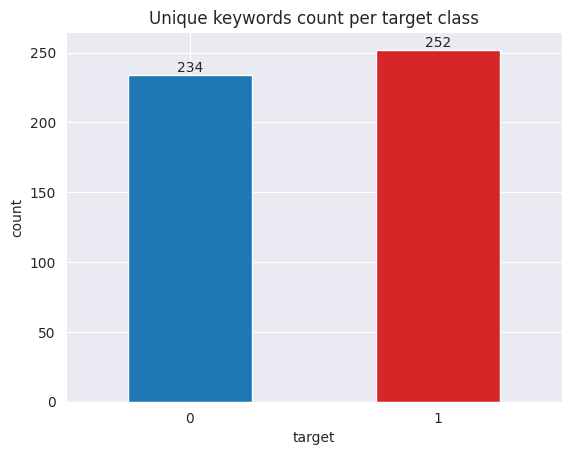

In [25]:
keywords_ct = df_train.groupby("target")["keyword"].nunique()
ax = keywords_ct.plot(kind="bar", rot=0, color=target_colors)

ax.set_ylabel("count")
ax.bar_label(ax.containers[0], labels=[val for val in ax.containers[0].datavalues])

plt.title("Unique keywords count per target class")
plt.show()

Top keywords for each target class

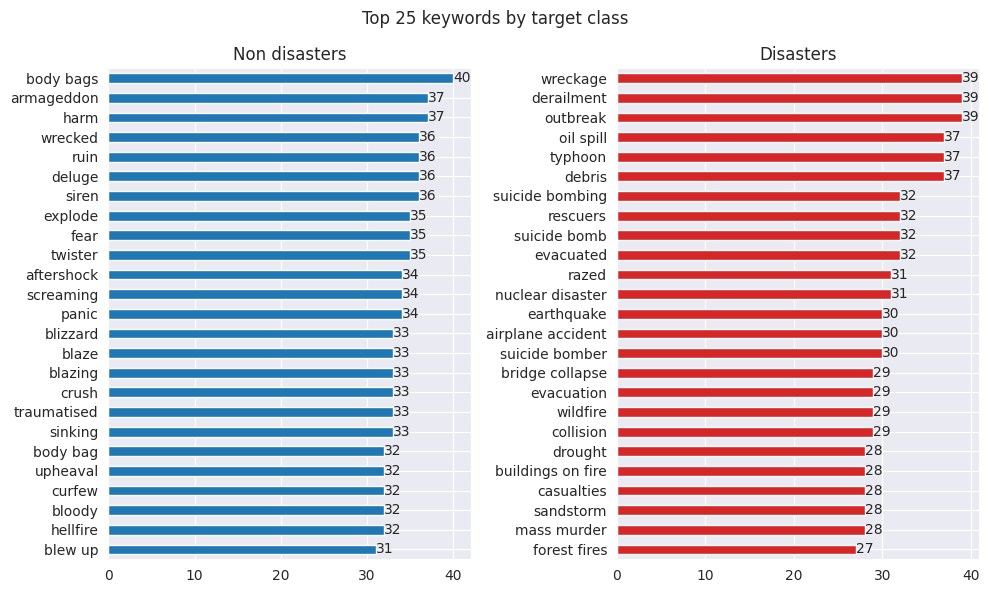

In [26]:
n = 25
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle(f"Top {n} keywords by target class")

for i, target in enumerate([("Non disasters", 0), ("Disasters", 1)]):
    t_title, t_class = target
    class_keywords = (
        df_train.query(f"target == {t_class}")["keyword"]
        .value_counts()
        .head(n)
        .sort_values()
    )
    class_keywords.plot(kind="barh", ax=axs[i], color=target_colors[i])

    axs[i].set_title(t_title)
    axs[i].set_ylabel(None)
    axs[i].bar_label(
        axs[i].containers[0],
        labels=[val for val in axs[i].containers[0].datavalues],
    )

plt.tight_layout()
plt.show()

Measurement of keywords association with real disasters.  
The more a keyword value gets close to 1, the more it is associated to a real accident.

In [27]:
keys_conf_rate = df_train.groupby("keyword")["target"].mean()

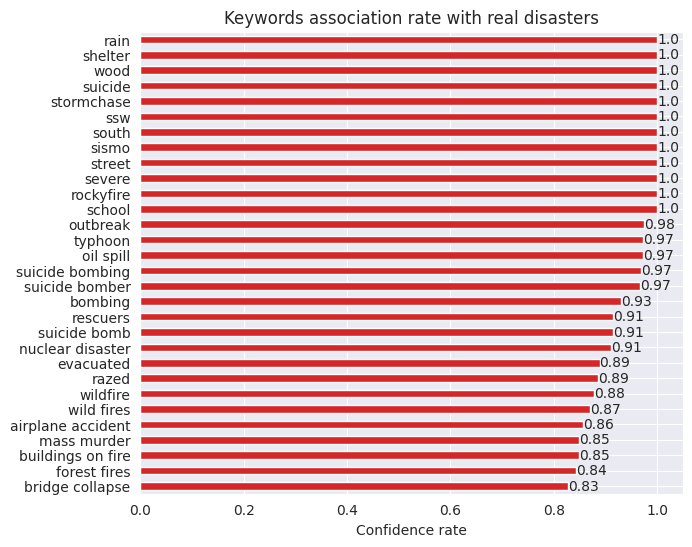

In [28]:
plt.figure(figsize=(7, 6))

ax = (
    keys_conf_rate[keys_conf_rate > 0.8]
    .sort_values()
    .head(30)
    .plot(kind="barh", color=target_colors[1])
)

plt.title("Keywords association rate with real disasters")
plt.ylabel(None)
plt.xlabel("Confidence rate")
plt.bar_label(
    ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
# plt.tight_layout()
plt.show()

### Tweet extra informations : hashtags, mentions, links

Not that many tweets have a hashtag and/or a mention.  
More than 50% of tweets have at least 1 link.

In [29]:
for info in ["hashtag", "link", "mention"]:
    query = df_train.query(f'{info} == "no"')
    print(f"No {info + ' ':-<13} {query.shape[0] / df_train.shape[0]}")

No hashtag ----- 0.7710495205569421
No link -------- 0.4783922238276632
No mention ----- 0.7361092867463549


Relation with target
- Are tweets including links more often associated with real disasters ?
- Same for mentions and hashtags

### RoBERTa sentiment analysis

Sentiment scores show plausible results :
- real disasters are mainly seen as negative
- false disasters are mainly seen as postive
- a high neutrality score for each class

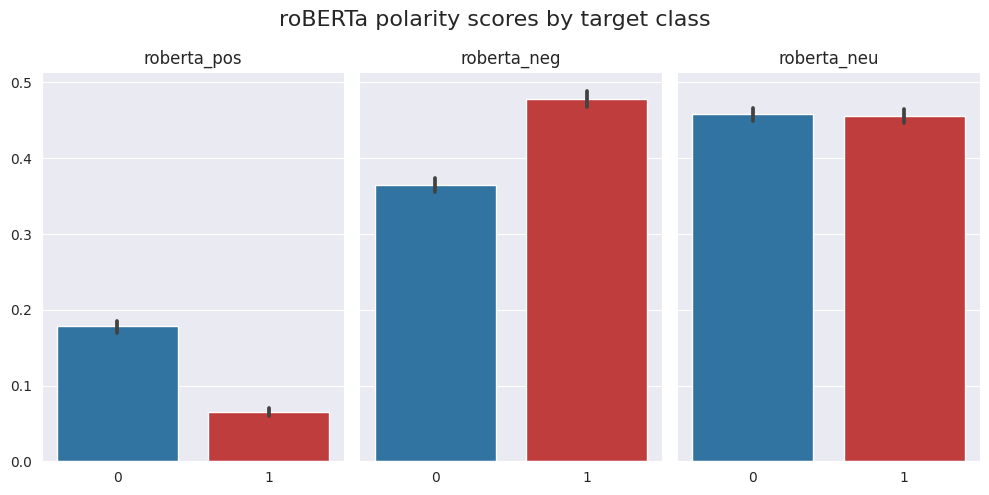

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle("roBERTa polarity scores by target class", fontsize=16)

for i, score in enumerate(["roberta_pos", "roberta_neg", "roberta_neu"]):
    sns.barplot(df_train, x="target", y=score, ax=axs[i], palette=target_colors)
    axs[i].set_title(score)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)

plt.tight_layout()
plt.show()

### Correlations

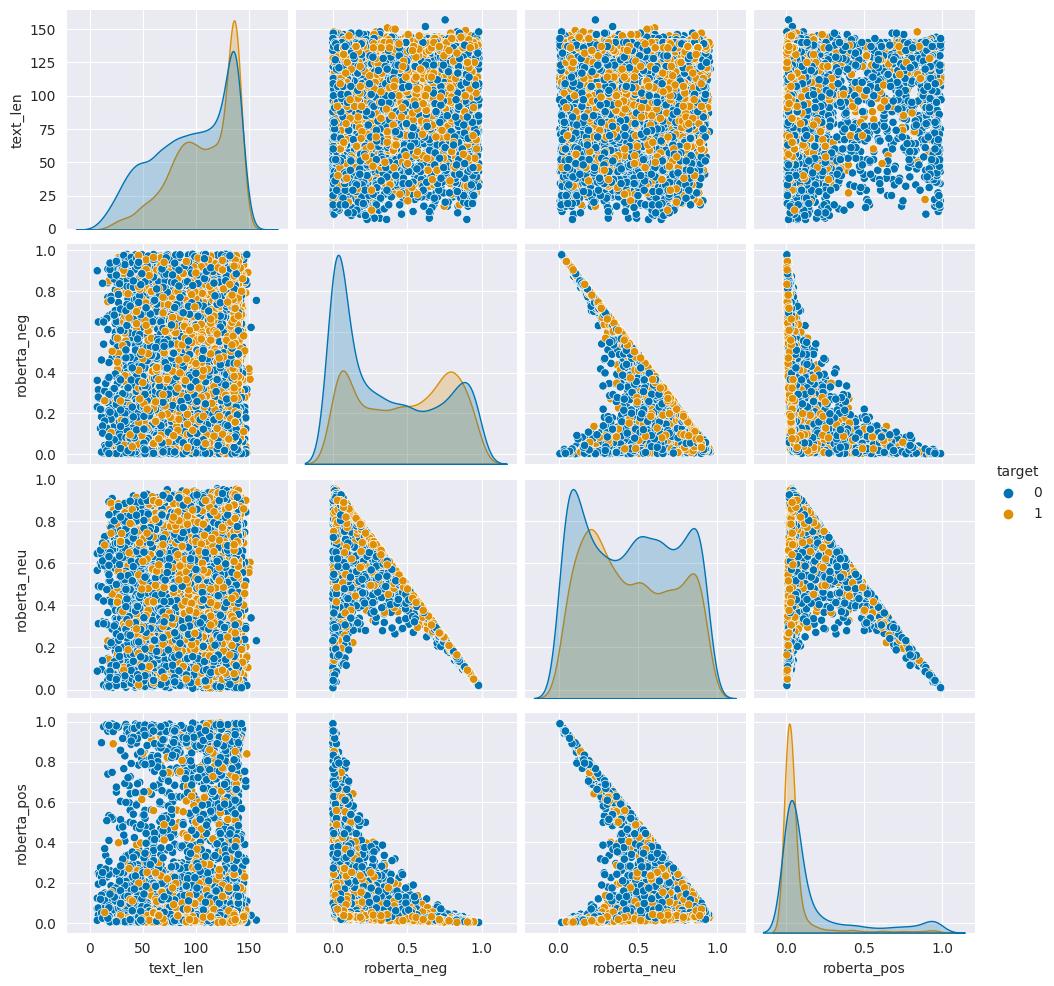

In [37]:
sns.pairplot(df_train.drop("id", axis=1), hue="target")
plt.show()

## ML modelization

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [148]:
# Parameters
t_size = 0.2
seed = 56
scale_cols = ["text_len"]
encode_cols = ["keyword", "mention", "hashtag"]
drop_cols = ["id", "link", "text", "text_clean", "text_nlp"]

scaler = StandardScaler()
encoder = LabelEncoder()
vectorizer = TfidfVectorizer()

In [147]:
def ml_prepocessing(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """Apply preprocessing for ml modelization."""
    df_ml = df.copy()

    # Pre-selection
    # df_ml = df_ml.drop(drop_cols, axis=1)

    # # Feature extraction

    # # Scaling
    # df_ml[scale_cols] = scaler.fit_transform(df_ml[scale_cols])

    # # Encoding
    # for col in encode_cols:
    #     df_ml[col] = encoder.fit_transform(df_ml[col])

    # X = df_ml.drop("target", axis=1)
    X = vectorizer.fit_transform(df_ml["text_clean"])
    y = df_ml["target"]

    return X, y

### Train/test spliting

In [149]:
X, y = ml_prepocessing(df_train)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=t_size,
    shuffle=True,
    random_state=seed,
)

In [151]:
print(X_train)

  (0, 9100)	0.4860138604597574
  (0, 17194)	0.4131325556352602
  (0, 4269)	0.3355400933274646
  (0, 15206)	0.4378419382399811
  (0, 17578)	0.23476220290125524
  (0, 18051)	0.23175722798453638
  (0, 18036)	0.18408839810652483
  (0, 14224)	0.28087643256284567
  (0, 2928)	0.19448864116176853
  (0, 8258)	0.1288921511713048
  (0, 16021)	0.11302862605567533
  (1, 11132)	0.3098649712965111
  (1, 4428)	0.28663172090512123
  (1, 13623)	0.3098649712965111
  (1, 11211)	0.29627439104768283
  (1, 13349)	0.26339847051373133
  (1, 3368)	0.3098649712965111
  (1, 2837)	0.1761602289844671
  (1, 7850)	0.3917239068911645
  (1, 371)	0.24980789026490316
  (1, 16186)	0.20334138948212344
  (1, 1021)	0.14723221855678206
  (1, 10071)	0.25591903447719017
  (1, 15171)	0.22023153283148877
  (1, 11654)	0.10963186295301265
  :	:
  (6088, 12592)	0.346546162751916
  (6088, 11941)	0.2793796453798411
  (6088, 1600)	0.24503125296598005
  (6088, 8787)	0.3053632011773959
  (6088, 1021)	0.16466127216903256
  (6088, 17582)	0

### Model evaluation

In [152]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [153]:
cv_params = {
    "cv": 5,
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "f1_micro",  # better choice because of class imbalances
    "shuffle": True,
    "random_state": seed,
}

In [154]:
def eval_model(model, X_train, y_train, X_test, y_test, **kwargs: dict):
    # Train model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Show results
    plt.figure(figsize=(9, 6))
    sns.heatmap(
        confusion_matrix(y_test, y_pred), square=True, annot=True, cbar=False, fmt="d"
    )
    print(classification_report(y_test, y_pred))

    # Cross-validation
    N, train_score, val_score = learning_curve(model, X_train, y_train, **kwargs)

    print(f"max validation score : {val_score.max()}")

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label="Training score")
    plt.plot(N, val_score.mean(axis=1), label="Cross validation score")
    plt.title(f'{type(model).__name__} cross validation, k_folds = {kwargs["cv"]}')
    plt.legend()

### Logistic regression

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       904
           1       0.84      0.68      0.75       619

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523

max validation score : 0.8177339901477833


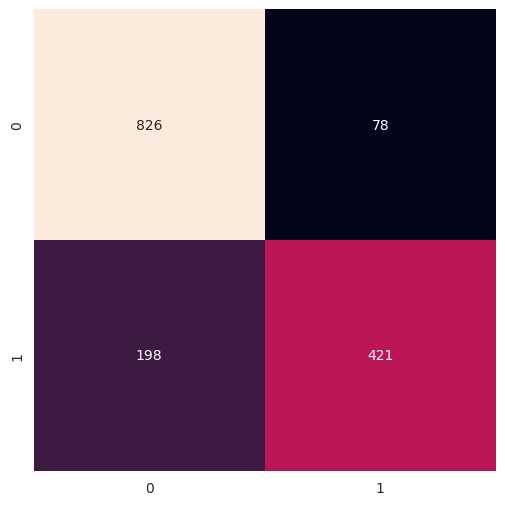

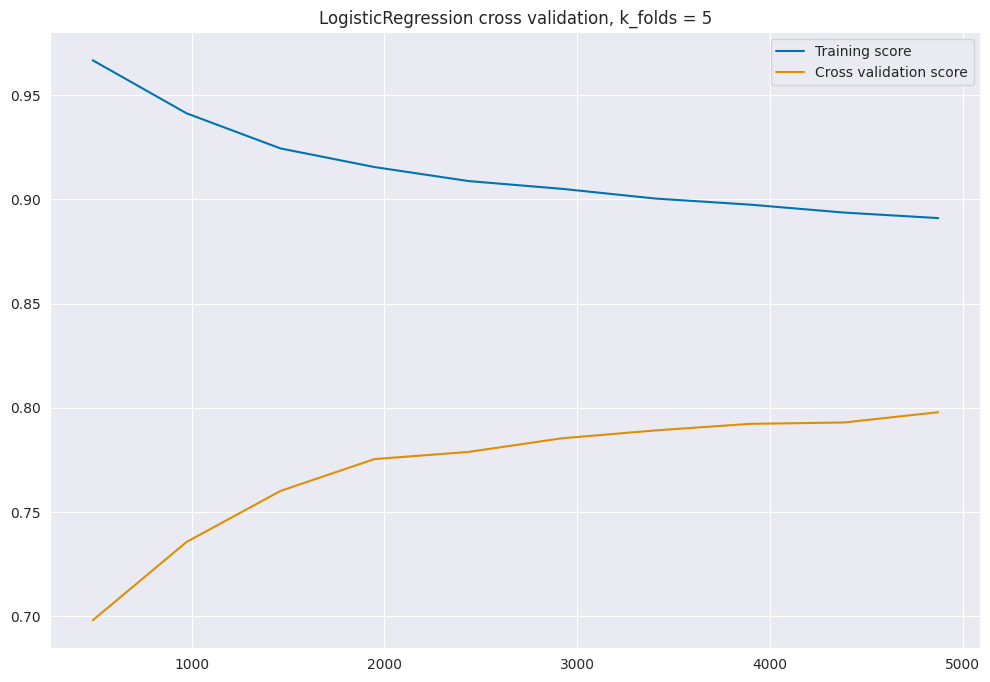

In [155]:
log_model = LogisticRegression(random_state=seed, max_iter=500)
eval_model(log_model, X_train, y_train, X_test, y_test, **cv_params)